In [1]:
import os
# numerical computing package
import numpy as np
# 
from scipy import stats
# command style functions that make matplotlib work like MATLAB
import matplotlib.pyplot as plt
# matplotlib
import matplotlib
# find nearest value
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()
#
import sys
#
import pickle
#
import xarray as xr
#
from glob import glob as gb
#
import time
#
import cartopy.crs as ccrs
#
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)

import cosima_cookbook as cc
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from glob import glob as gb
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

session = cc.database.create_session()

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
!pwd

figures_path = '/home/561/erd561/figures/JRA_IAF_v13/'
script_name = nb_name[:-6]
print('Figures will be saved in: ' + figures_path + script_name + '\n')

data_path = '/g/data/e14/erd561/'

years = arange(1993,2017,1)

/home/561/erd561/wombat_jra-iaf_mom025
Figures will be saved in: /home/561/erd561/figures/JRA_IAF_v13/p01_SST_SSH



In [4]:
%%time

from dask.distributed import Client
c = Client()
print(c)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:36312' processes=4 threads=8, memory=33.67 GB>
CPU times: user 612 ms, sys: 257 ms, total: 869 ms
Wall time: 4.18 s


In [5]:
input_path = '/g/data/e14/erd561/NOAA_OI_SST_V2/'

years_SST = np.arange(1982,2018)

lonW = 100
lonE = 170

latS = -60
latN = -20

sst = xr.open_dataset(input_path + 'sst.mnmean.nc').\
                sst.\
                sel(lon=slice(lonW,lonE)).\
                sel(lat=slice(latS,latN,-1)).\
                groupby('time.year').\
                mean('time', skipna=True).\
                sel(year=slice(1982,2017))

sst = sst.assign_coords(lon=sst.lon)

mask = xr.open_dataset(input_path + 'lsmask.nc').\
                mask.\
                sel(lon=slice(lonW,lonE)).\
                sel(lat=slice(latS,latN,-1))

mask = mask.assign_coords(lon=mask.lon)

sst = sst.where(mask==1, np.nan)

sst = sst.squeeze()
print(sst)

sea_surface_temperature = sst

<xarray.DataArray 'sst' (year: 36, lat: 40, lon: 70)>
array([[[-2.8583333e-01, -2.4333334e-01, -2.2000001e-01, ...,
          3.7808332e+00,  4.0941663e+00,  4.3058329e+00],
        [-1.3333333e-01, -1.1750000e-01, -1.0750001e-01, ...,
          4.6075001e+00,  4.9775000e+00,  5.1949992e+00],
        [ 2.0000001e-02,  1.6666675e-03, -6.6666654e-03, ...,
          5.4441662e+00,  5.7749996e+00,  5.9483333e+00],
        ...,
        [ 2.2434998e+01,  2.2428331e+01,  2.2474165e+01, ...,
          2.4290833e+01,  2.4195837e+01,  2.4211664e+01],
        [ 2.3062498e+01,  2.3081665e+01,  2.3138334e+01, ...,
          2.4818335e+01,  2.4725000e+01,  2.4739998e+01],
        [ 2.3627497e+01,  2.3676666e+01,  2.3751669e+01, ...,
          2.5331665e+01,  2.5235001e+01,  2.5245001e+01]],

       [[ 3.0999991e-01,  3.9750004e-01,  4.6249989e-01, ...,
          3.3583333e+00,  3.5583334e+00,  3.7183332e+00],
        [ 4.8250005e-01,  5.5500001e-01,  6.2083334e-01, ...,
          4.2658334e+00,  4.4

In [6]:
# sea_surface_temperature_path = data_path + 'IMOS/IMOS_aggregation_SSTAARS_20181023T031550Z.nc'
# for Y in years:
#     y = int(Y)
#     if y == 1993:
#         sea_surface_temperature = xr.open_dataset(
#         sea_surface_temperature_path).sea_surface_temperature.\
#         sel(time=slice(str(y) + '-01-01', str(y+1) + '-01-01')).\
#         sel(lon=arange(100,170,0.25), method='nearest').\
#         sel(lat=arange(-20,-60,-0.25), method='nearest').\
#         mean(dim='time').assign_coords(year=y)
#     else:
#         sea_surface_temperature = xr.concat([
#         sea_surface_temperature,
#         xr.open_dataset(sea_surface_temperature_path).sea_surface_temperature.\
#         sel(time=slice(str(y) + '-01-01', str(y+1) + '-01-01')).\
#         sel(lon=arange(100,170,0.25), method='nearest').\
#         sel(lat=arange(-20,-60,-0.25), method='nearest').\
#         mean(dim='time').assign_coords(year=y)
#         ], 'year')
#     print(y)
# print(sea_surface_temperature)

In [7]:
AVISO_list = sorted(gb(data_path + 'AVISO/dt_global_allsat_msla_h_y*.nc'))
AVISO_list

GSLA = xr.open_mfdataset(AVISO_list).sla.\
        sel(lon=slice(100,170)).\
        sel(lat=slice(-60,-20)) *100

print(GSLA)

GSLA = GSLA.sel(time=slice('1993-01-01', '2017-12-31')).groupby('time.year').mean('time')
GSLA.load()
print(GSLA)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.DataArray 'sla' (time: 312, lat: 160, lon: 280)>
dask.array<mul, shape=(312, 160, 280), dtype=float64, chunksize=(1, 160, 280), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -59.875 -59.625 -59.375 ... -20.625 -20.375 -20.125
  * lon      (lon) float32 100.125 100.375 100.625 ... 169.375 169.625 169.875
  * time     (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2018-12-15
<xarray.DataArray 'sla' (year: 25, lat: 160, lon: 280)>
array([[[-4.18166667, -4.22416667, -4.24166667, ..., -1.91916667,
         -2.15416667, -2.5075    ],
        [-4.205     , -4.04666667, -3.86916667, ..., -3.1625    ,
         -3.615     , -3.9275    ],
        [-4.04583333, -3.73333333, -3.4525    , ..., -0.60666667,
         -0.80916667, -0.88166667],
        ...,
        [-4.65166667, -4.49083333, -4.42333333, ..., -0.66      ,
         -0.51083333, -0.43      ],
        [-4.49583333, -4.46666667, -4.50833333, ..., -1.03666667,
         -0.96166667, -0.975     ],
        [-4.45083

In [8]:
years_mod = np.arange(2218, 2258)
years_id = np.arange(2218, 2258, 2)
n_years = np.arange(1978, 2018)

print(years_mod)
print(len(years_mod))

output_n = ["%03d" % i for i in range(130,150)]
print(output_n)
print(len(output_n))

# use common start and end dates for all runs
# tstart = exptdata.clim_tstart
tstart = '1978-01-01 00:00:00'
tend = exptdata.clim_tend

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)


latS = -60
latN = -20
lonW = -260
lonE = -190
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
temp_month = cc.querying.getvar(expt=expt,
                                variable='temp',
                                session=session,
                                ncfile='ocean.nc',
                                n=n_files,
                                offset=offset).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            sel(st_ocean=0,method='nearest')

temp_month.load()

temp = temp_month.groupby('time.year').mean('time')
temp = temp.sel(year=slice(1978,2017))

xt_ocean = temp.xt_ocean
xt_ocean_corrected = xt_ocean + 360
temp = temp.assign_coords(xt_ocean=xt_ocean_corrected)
print(temp)

[2218 2219 2220 2221 2222 2223 2224 2225 2226 2227 2228 2229 2230 2231
 2232 2233 2234 2235 2236 2237 2238 2239 2240 2241 2242 2243 2244 2245
 2246 2247 2248 2249 2250 2251 2252 2253 2254 2255 2256 2257]
40
['130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149']
20
1978-2017
tstart =  1978-01-01 00:00:00
tend =  2018-01-01 00:00:00
025deg_jra55v13_iaf_gmredi6
days since 1718-01-01
-34
-87658


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

<xarray.DataArray 'temp' (year: 40, yt_ocean: 220, xt_ocean: 280)>
array([[[272.5063 , 272.5297 , 272.5534 , ..., 276.11627, 276.16214,
         276.22318],
        [272.5527 , 272.57562, 272.59445, ..., 276.19135, 276.24188,
         276.30597],
        [272.59995, 272.6216 , 272.63828, ..., 276.27237, 276.32352,
         276.38934],
        ...,
        [296.34662, 296.3134 , 296.29318, ..., 297.9321 , 297.93143,
         297.9177 ],
        [296.4749 , 296.45575, 296.4578 , ..., 298.0363 , 298.02942,
         298.02402],
        [296.646  , 296.62845, 296.5906 , ..., 298.1591 , 298.15842,
         298.14905]],

       [[272.9055 , 272.922  , 272.93787, ..., 275.9116 , 275.9297 ,
         275.98596],
        [272.93976, 272.95718, 272.96857, ..., 276.00165, 276.0128 ,
         276.0658 ],
        [272.9709 , 272.98734, 272.9991 , ..., 276.09915, 276.1147 ,
         276.15906],
        ...,
        [296.21423, 296.20197, 296.1811 , ..., 298.13962, 298.15198,
         298.14557],
     

In [9]:
eta_t_month = cc.querying.getvar(expt=expt,
                                variable='eta_t',
                                session=session,
                                ncfile='ocean_month.nc',
                                n=n_files,
                                offset=offset).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE))

eta_t_month.load()

eta_t = eta_t_month.groupby('time.year').mean('time')*100
eta_t = eta_t.sel(year=slice(1978,2017))

xt_ocean = eta_t.xt_ocean
xt_ocean_corrected = xt_ocean + 360
eta_t = eta_t.assign_coords(xt_ocean=xt_ocean_corrected)
print(eta_t)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cosima_cookbook/querying.py:96: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  preprocess=lambda d: d[variable].to_dataset() if variable not in d.coords else d)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option t

<xarray.DataArray 'eta_t' (year: 40, yt_ocean: 220, xt_ocean: 280)>
array([[[-181.71002 , -181.51251 , -181.2364  , ..., -126.04009 ,
         -125.4059  , -124.51856 ],
        [-180.96219 , -180.72826 , -180.43765 , ..., -124.47202 ,
         -123.763885, -122.86788 ],
        [-180.12553 , -179.84508 , -179.58464 , ..., -122.73176 ,
         -122.042534, -121.14519 ],
        ...,
        [  39.09323 ,   38.785072,   38.66992 , ...,   61.674988,
           61.77823 ,   61.662273],
        [  40.20345 ,   40.005352,   39.85035 , ...,   61.901146,
           62.018276,   62.04215 ],
        [  41.321228,   41.197594,   41.071365, ...,   62.122047,
           62.269264,   62.23868 ]],

       [[-183.39749 , -183.18996 , -182.90442 , ..., -126.25247 ,
         -125.99042 , -125.184906],
        [-182.70668 , -182.46194 , -182.15182 , ..., -124.65397 ,
         -124.35886 , -123.58893 ],
        [-181.93507 , -181.64488 , -181.35046 , ..., -122.897316,
         -122.60698 , -121.853386],

In [10]:
%%time
lon = sea_surface_temperature.lon
lat = sea_surface_temperature.lat
time = years_SST
sea_surface_temperature_anom_82 = \
sea_surface_temperature - sea_surface_temperature.mean(dim='year')
sea_surface_temperature_slopes_82 = xr.DataArray(
    np.zeros([lat.shape[0], lon.shape[0]]), dims=(
    'lat', 'lon'), 
    coords=[lat, lon], name='sea_surface_temperature')
for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):        
        sea_surface_temperature_slopes_82[iid, jid], _, _, _, _ = \
        stats.linregress(time, sea_surface_temperature_anom_82.sel(lon=j, lat=i))
    print('lat ' + str(np.array(i)))
print(sea_surface_temperature_slopes_82)

time = arange(1993,2017)
sea_surface_temperature_anom_93 = \
sea_surface_temperature.sel(year=slice(1993,2017)) - \
sea_surface_temperature.sel(year=slice(1993,2017)).mean(dim='year')
sea_surface_temperature_slopes_93 = xr.DataArray(
    np.zeros([lat.shape[0], lon.shape[0]]), dims=(
    'lat', 'lon'), 
    coords=[lat, lon], name='sea_surface_temperature')
for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):        
        sea_surface_temperature_slopes_93[iid, jid], _, _, _, _ = \
        stats.linregress(time, sea_surface_temperature_anom_93.sel(lon=j, lat=i))
    print('lat ' + str(np.array(i)))
print(sea_surface_temperature_slopes_93)



temp_anom_93 = temp.sel(year=slice(1993,2017)) - temp.sel(year=slice(1993,2017)).mean(dim='year')
temp_anom_82 = temp.sel(year=slice(1982,2017)) - temp.sel(year=slice(1982,2017)).mean(dim='year')
eta_t_anom = eta_t.sel(year=slice(1993,2017)) - eta_t.sel(year=slice(1993,2017)).mean(dim='year')

yt_ocean = temp.yt_ocean
xt_ocean = temp.xt_ocean
temp_slopes_93 = xr.DataArray(np.zeros([yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yt_ocean, xt_ocean], name='temp')
for iid, i in enumerate(yt_ocean):
    for jid, j in enumerate(xt_ocean):
        temp_slopes_93[iid, jid], _, _, _, _ = \
        stats.linregress(arange(1993,2017), temp_anom_93.sel(xt_ocean=j, yt_ocean=i))
    print('lat ' + str(np.array(i)))
print(temp_slopes_93)    

yt_ocean = temp.yt_ocean
xt_ocean = temp.xt_ocean
temp_slopes_82 = xr.DataArray(np.zeros([yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yt_ocean, xt_ocean], name='temp')
for iid, i in enumerate(yt_ocean):
    for jid, j in enumerate(xt_ocean):
        temp_slopes_82[iid, jid], _, _, _, _ = \
        stats.linregress(years_SST, temp_anom_82.sel(xt_ocean=j, yt_ocean=i))
    print('lat ' + str(np.array(i)))
print(temp_slopes_82)   

eta_t_slopes = xr.DataArray(np.zeros([yt_ocean.shape[0], xt_ocean.shape[0]]), dims=(
    'latitude', 'longitude'), coords=[yt_ocean, xt_ocean], name='eta_t')
for iid, i in enumerate(yt_ocean):
    for jid, j in enumerate(xt_ocean):        
        eta_t_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(arange(1993,2017), eta_t_anom.sel(xt_ocean=j, yt_ocean=i))
    print('lat ' + str(np.array(i)))
print(eta_t_slopes)



lon = GSLA.lon
lat = GSLA.lat
time = years
GSLA_anom = GSLA - GSLA.mean(dim='year')
GSLA_slopes = xr.DataArray(
    np.zeros([lat.shape[0], lon.shape[0]]), dims=(
    'lat', 'lon'), 
    coords=[lat, lon], name='GSLA')
for iid, i in enumerate(lat):
    for jid, j in enumerate(lon):        
        GSLA_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(time, GSLA_anom.sel(lon=j, lat=i))
    print('lat ' + str(np.array(i)))
print(GSLA_slopes)

lat -59.5
lat -58.5
lat -57.5
lat -56.5
lat -55.5
lat -54.5
lat -53.5
lat -52.5
lat -51.5
lat -50.5
lat -49.5
lat -48.5
lat -47.5
lat -46.5
lat -45.5
lat -44.5
lat -43.5
lat -42.5
lat -41.5
lat -40.5
lat -39.5
lat -38.5
lat -37.5
lat -36.5
lat -35.5
lat -34.5
lat -33.5
lat -32.5
lat -31.5
lat -30.5
lat -29.5
lat -28.5
lat -27.5
lat -26.5
lat -25.5
lat -24.5
lat -23.5
lat -22.5
lat -21.5
lat -20.5
<xarray.DataArray 'sea_surface_temperature' (lat: 40, lon: 70)>
array([[0.00086915, 0.00150826, 0.00189114, ..., 0.00418425, 0.00708515,
        0.00990336],
       [0.00145871, 0.00256768, 0.00330856, ..., 0.0056968 , 0.00808172,
        0.00992085],
       [0.00110586, 0.00164017, 0.0023462 , ..., 0.00363106, 0.00505374,
        0.00546751],
       ...,
       [0.00740071, 0.0084615 , 0.00941939, ..., 0.01591662, 0.01666096,
        0.01685319],
       [0.00859205, 0.00958722, 0.01044121, ..., 0.01702132, 0.01785553,
        0.01777567],
       [0.00918203, 0.01008194, 0.01078819, ..., 0.017

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


lat -59.5
lat -58.5
lat -57.5
lat -56.5
lat -55.5
lat -54.5
lat -53.5
lat -52.5
lat -51.5
lat -50.5
lat -49.5
lat -48.5
lat -47.5
lat -46.5
lat -45.5
lat -44.5
lat -43.5
lat -42.5
lat -41.5
lat -40.5
lat -39.5
lat -38.5
lat -37.5
lat -36.5
lat -35.5
lat -34.5
lat -33.5
lat -32.5
lat -31.5
lat -30.5
lat -29.5
lat -28.5
lat -27.5
lat -26.5
lat -25.5
lat -24.5
lat -23.5
lat -22.5
lat -21.5
lat -20.5
<xarray.DataArray 'sea_surface_temperature' (lat: 40, lon: 70)>
array([[-0.00500449, -0.00511475, -0.00507051, ...,  0.00753077,
         0.0053391 ,  0.00443717],
       [-0.00513974, -0.00475961, -0.00441154, ...,  0.00815255,
         0.00509167,  0.0031269 ],
       [-0.00509679, -0.00517949, -0.00489872, ...,  0.00520833,
         0.00195385, -0.00099551],
       ...,
       [ 0.01290896,  0.01292626,  0.01271993, ...,  0.01788776,
         0.01742499,  0.01803198],
       [ 0.01311928,  0.01316347,  0.01279422, ...,  0.01817941,
         0.01769866,  0.01810317],
       [ 0.01430322,  0.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


lat -59.95944891414468
lat -59.83405816024584
lat -59.70819585940245
lat -59.581856103011404
lat -59.45504242360883
lat -59.32774895769571
lat -59.19997921240009
lat -59.071727369439934
lat -58.942996911365846
lat -58.81378206523734
lat -58.68408628986453
lat -58.55390385778473
lat -58.42323820491095
lat -58.29208364940619
lat -58.16044360513618
lat -58.02831243604918
lat -57.89569353481996
lat -57.76258131135323
lat -57.62897913799566
lat -57.4948814707912
lat -57.360291662627816
lat -57.22520421588314
lat -57.08962246486236
lat -56.95354095848275
lat -56.816963013349266
lat -56.67988322513629
lat -56.542304893637656
lat -56.40422266151375
lat -56.26563981264301
lat -56.12655103691214
lat -55.98695960318641
lat -55.84686024883049
lat -55.706256228605255
lat -55.56514232761621
lat -55.423521787435156
lat -55.281389441182455
lat -55.13874851816258
lat -54.99559389979584
lat -54.85192880404753
lat -54.70774816093398
lat -54.56305517801577
lat -54.417844834212126
lat -54.2721203276197
lat

lat -46.655535945152195
lat -46.48366709260396
lat -46.31125528258984
lat -46.1382969041921
lat -45.96479525661064
lat -45.79074678944065
lat -45.6161548195597
lat -45.441015857585846
lat -45.26533323910572
lat -45.089103536271594
lat -44.91233010440849
lat -44.735009577715175
lat -44.557145332281756
lat -44.37873406486607
lat -44.19977917334686
lat -44.020277417553295
lat -43.84023221817254
lat -43.65964039861644
lat -43.47850540339607
lat -43.29682412001572
lat -43.1146000178209
lat -42.93183004891588
lat -42.748517708485565
lat -42.564660013738866
lat -42.38026048669883
lat -42.19531621018006
lat -42.00983073403561
lat -41.82380120718251
lat -41.637231208288156
lat -41.45011795286375
lat -41.262465049367066
lat -41.07426978038944
lat -40.88553578514614
lat -40.696260413788075
lat -40.506447337245405
lat -40.31609397370077
lat -40.125204026746204
lat -39.93377498306014
lat -39.7418105798323
lat -39.549308372692096
lat -39.35627213335076
lat -39.16269948683419
lat -38.96859424028622
l

lat -27.28160724647727
lat -27.059193280207044
lat -26.83633873488693
lat -26.61304344089147
lat -26.389312594451354
lat -25.037894722851966
lat -24.811177907964588
lat -24.58404690794839
lat -24.356501917704698
lat -24.12854839748857
lat -23.90018661382929
lat -23.671422079652153
lat -23.442255132597825
lat -23.212691338122195
lat -22.982731104420896
lat -22.75238004929935
lat -22.52163865091151
lat -22.290512579189507
lat -22.05900238160839
lat -21.827113779962115
lat -21.594847390368724
lat -21.362208986176793
lat -21.129199251428126
lat -20.89582401067619
lat -20.66208401512598
lat -20.427985140143456
lat -20.193528203294715
<xarray.DataArray 'eta_t' (latitude: 220, longitude: 280)>
array([[ 0.02813075,  0.03111828,  0.0338455 , ..., -0.0880395 ,
        -0.09133706, -0.09327969],
       [ 0.02959295,  0.03273027,  0.03504586, ..., -0.10285032,
        -0.10363027, -0.10340821],
       [ 0.02978918,  0.0331412 ,  0.03521937, ..., -0.11626769,
        -0.11659684, -0.11451143],
    

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


lat -59.875
lat -59.625
lat -59.375
lat -59.125
lat -58.875
lat -58.625
lat -58.375
lat -58.125
lat -57.875
lat -57.625
lat -57.375
lat -57.125
lat -56.875
lat -56.625
lat -56.375
lat -56.125
lat -55.875
lat -55.625
lat -55.375
lat -55.125
lat -54.875
lat -54.625
lat -54.375
lat -54.125
lat -53.875
lat -53.625
lat -53.375
lat -53.125
lat -52.875
lat -52.625
lat -52.375
lat -52.125
lat -51.875
lat -51.625
lat -51.375
lat -51.125
lat -50.875
lat -50.625
lat -50.375
lat -50.125
lat -49.875
lat -49.625
lat -49.375
lat -49.125
lat -48.875
lat -48.625
lat -48.375
lat -48.125
lat -47.875
lat -47.625
lat -47.375
lat -47.125
lat -46.875
lat -46.625
lat -46.375
lat -46.125
lat -45.875
lat -45.625
lat -45.375
lat -45.125
lat -44.875
lat -44.625
lat -44.375
lat -44.125
lat -43.875
lat -43.625
lat -43.375
lat -43.125
lat -42.875
lat -42.625
lat -42.375
lat -42.125
lat -41.875
lat -41.625
lat -41.375
lat -41.125
lat -40.875
lat -40.625
lat -40.375
lat -40.125
lat -39.875
lat -39.625
lat -39.375
lat 

In [11]:
lon_SA = [112, 145]
lat_SA = [-41, -31]
sea_surface_temperature_anom_SA_82 = sea_surface_temperature_anom_82.\
sel(lon=slice(lon_SA[0],lon_SA[1])).\
sel(lat=slice(lat_SA[0],lat_SA[1])).\
mean(dim='lon').\
mean(dim='lat')
sea_surface_temperature_anom_SA_slope_82, sea_surface_temperature_anom_SA_intrsct_82, _, _, _ = \
        stats.linregress(years_SST, sea_surface_temperature_anom_SA_82)

sea_surface_temperature_anom_SA_93 = sea_surface_temperature_anom_93.\
sel(lon=slice(lon_SA[0],lon_SA[1])).\
sel(lat=slice(lat_SA[0],lat_SA[1])).\
mean(dim='lon').\
mean(dim='lat')
sea_surface_temperature_anom_SA_slope_93, sea_surface_temperature_anom_SA_intrsct_93, _, _, _ = \
        stats.linregress(arange(1993,2017), sea_surface_temperature_anom_SA_93)


lon_TS = [148, 157]
lat_TS = [-45, -32]
sea_surface_temperature_anom_TS_82 = sea_surface_temperature_anom_82.\
sel(lon=slice(lon_TS[0],lon_TS[1])).\
sel(lat=slice(lat_TS[0],lat_TS[1])).\
mean(dim='lon').\
mean(dim='lat')
sea_surface_temperature_anom_TS_slope_82, sea_surface_temperature_anom_TS_intrsct_82, _, _, _ = \
        stats.linregress(years_SST, sea_surface_temperature_anom_TS_82)
sea_surface_temperature_anom_TS_93 = sea_surface_temperature_anom_93.\
sel(lon=slice(lon_TS[0],lon_TS[1])).\
sel(lat=slice(lat_TS[0],lat_TS[1])).\
mean(dim='lon').\
mean(dim='lat')
sea_surface_temperature_anom_TS_slope_93, sea_surface_temperature_anom_TS_intrsct_93, _, _, _ = \
        stats.linregress(arange(1993,2017), sea_surface_temperature_anom_TS_93)
GSLA_anom_TS = GSLA_anom.\
sel(lon=slice(lon_TS[0],lon_TS[1])).\
sel(lat=slice(lat_TS[0],lat_TS[1])).\
mean(dim='lon').\
mean(dim='lat')
GSLA_anom_TS_slope, GSLA_anom_TS_intrsct, _, _, _ = \
        stats.linregress(years, GSLA_anom_TS)
    
print('OK')

OK


In [12]:
xt_ocean_SA = [112, 145]
yt_ocean_SA = [-41, -31]
temp_anom_SA_82 = temp_anom_82.\
sel(xt_ocean=slice(xt_ocean_SA[0],xt_ocean_SA[1])).\
sel(yt_ocean=slice(yt_ocean_SA[0],yt_ocean_SA[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_SA_slope_82, temp_anom_SA_intrsct_82, _, _, _ = \
        stats.linregress(years_SST, temp_anom_SA_82)

temp_anom_SA_93 = temp_anom_93.\
sel(xt_ocean=slice(xt_ocean_SA[0],xt_ocean_SA[1])).\
sel(yt_ocean=slice(yt_ocean_SA[0],yt_ocean_SA[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_SA_slope_93, temp_anom_SA_intrsct_93, _, _, _ = \
        stats.linregress(arange(1993,2017), temp_anom_SA_93)


xt_ocean_TS = [148, 157]
yt_ocean_TS = [-45, -32]
temp_anom_TS_82 = temp_anom_82.\
sel(xt_ocean=slice(xt_ocean_TS[0],xt_ocean_TS[1])).\
sel(yt_ocean=slice(yt_ocean_TS[0],yt_ocean_TS[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_TS_slope_82, temp_anom_TS_intrsct_82, _, _, _ = \
        stats.linregress(years_SST, temp_anom_TS_82)
temp_anom_TS_93 = temp_anom_93.\
sel(xt_ocean=slice(xt_ocean_TS[0],xt_ocean_TS[1])).\
sel(yt_ocean=slice(yt_ocean_TS[0],yt_ocean_TS[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
temp_anom_TS_slope_93, temp_anom_TS_intrsct_93, _, _, _ = \
        stats.linregress(arange(1993,2017), temp_anom_TS_93)
eta_t_anom_TS = eta_t_anom.\
sel(xt_ocean=slice(xt_ocean_TS[0],xt_ocean_TS[1])).\
sel(yt_ocean=slice(yt_ocean_TS[0],yt_ocean_TS[1])).\
mean(dim='xt_ocean').\
mean(dim='yt_ocean')
eta_t_anom_TS_slope, eta_t_anom_TS_intrsct, _, _, _ = \
        stats.linregress(years, eta_t_anom_TS)
    
print('OK')

OK


In [52]:
years

array([1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000., 2001.,
       2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017.])

Bbox(x0=0.125, y0=0.7158695652173913, x1=0.35294117647058826, y1=0.88)
[0.125, 0.7558695652173913, 0.35294117647058826, 0.88]
Bbox(x0=0.3985294117647059, y0=0.7158695652173913, x1=0.6264705882352941, y1=0.88)
[0.3985294117647059, 0.7558695652173913, 0.6264705882352941, 0.88]
Bbox(x0=0.6720588235294118, y0=0.7158695652173913, x1=0.9000000000000001, y1=0.88)
[0.6720588235294118, 0.7558695652173913, 0.9000000000000001, 0.88]
Bbox(x0=0.125, y0=0.5189130434782608, x1=0.35294117647058826, y1=0.6830434782608695)
[0.125, 0.5189130434782608, 0.34294117647058825, 0.6330434782608695]
Bbox(x0=0.3985294117647059, y0=0.5189130434782608, x1=0.6264705882352941, y1=0.6830434782608695)
[0.3985294117647059, 0.5189130434782608, 0.6164705882352941, 0.6330434782608695]
Bbox(x0=0.6720588235294118, y0=0.5189130434782608, x1=0.9000000000000001, y1=0.6830434782608695)
[0.6720588235294118, 0.5189130434782608, 0.8900000000000001, 0.6330434782608695]
Bbox(x0=0.125, y0=0.32195652173913036, x1=0.35294117647058826, y

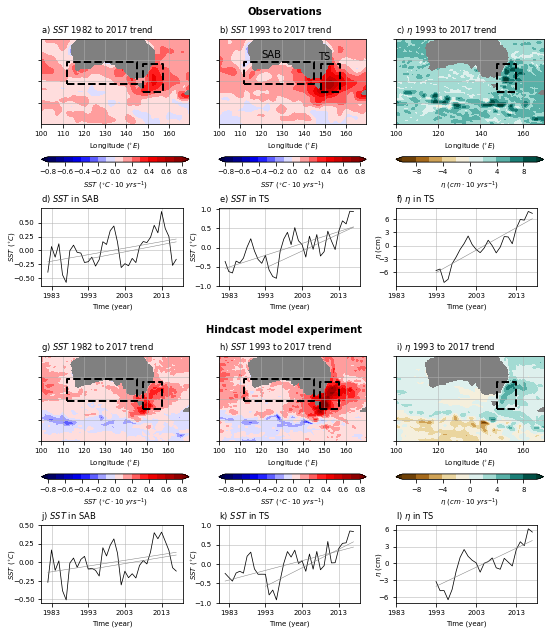

In [55]:
def bbox(pos):
    return matplotlib.transforms.Bbox(np.array([[pos[0],pos[1]],[pos[2],pos[3]]]))
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
row = 4
col = 3
fig = plt.figure()
fig.set_size_inches(9,9.5)
matplotlib.rcParams.update({'font.size': 7}) 


fig.text(x=0.5, y=0.915, s='Observations', fontsize=10, fontweight='bold', ha='center')
fig.text(x=0.5, y=0.45, s='Hindcast model experiment', fontsize=10, fontweight='bold', ha='center')

##########################################################################################
ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.04, pos.x1, pos.y1] 
print(pos_plot)

temp_slopes_40 = sea_surface_temperature_slopes_82 * 10
levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_slopes_40.lon, temp_slopes_40.lat, temp_slopes_40,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

# plt.text(120,-29,'SAB',color='k',fontsize=10)
# plt.text(147,-30,'TS',color='k',fontsize=10)
plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)
plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'a) $SST$ 1982 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,10))
# plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST\ (^{\circ}C \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.04, pos.x1, pos.y1] 
print(pos_plot)

temp_slopes_40 = sea_surface_temperature_slopes_93 * 10
levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_slopes_40.lon, temp_slopes_40.lat, temp_slopes_40,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.text(120,-29,'SAB',color='k',fontsize=10)
plt.text(147,-30,'TS',color='k',fontsize=10)
plt.plot(
    [lon_SA[0], lon_SA[1], lon_SA[1], lon_SA[0], lon_SA[0]],
    [lat_SA[0], lat_SA[0], lat_SA[1], lat_SA[1], lat_SA[0]],
    color='k', linestyle='--', linewidth=2)
plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'b) $SST$ 1993 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,10))
# plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST\ (^{\circ}C \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0+0.04, pos.x1, pos.y1] 
print(pos_plot)

eta_t_slopes_40 = GSLA_slopes * 10
levels = arange(-10,10,2)
plot = plt.contourf(eta_t_slopes_40.lon, eta_t_slopes_40.lat, eta_t_slopes_40,
            cmap='BrBG', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [lon_TS[0], lon_TS[1], lon_TS[1], lon_TS[0], lon_TS[0]],
    [lat_TS[0], lat_TS[0], lat_TS[1], lat_TS[1], lat_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'c) $\eta$ 1993 to 2017 trend', loc='left')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
# plt.ylabel('Latitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$\eta\ (cm \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.01, pos.y1-0.05] 
print(pos_plot)

plot = sea_surface_temperature_anom_SA_82.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years_SST[0], years_SST[-1]], 
    [years_SST[0]*sea_surface_temperature_anom_SA_slope_82+sea_surface_temperature_anom_SA_intrsct_82, 
     years_SST[-1]*sea_surface_temperature_anom_SA_slope_82+sea_surface_temperature_anom_SA_intrsct_82], 
    color='gray', linewidth=0.5)

plt.plot(
    [arange(1993,2017)[0], arange(1993,2017)[-1]], 
    [arange(1993,2017)[0]*sea_surface_temperature_anom_SA_slope_93+sea_surface_temperature_anom_SA_intrsct_93, 
     arange(1993,2017)[-1]*sea_surface_temperature_anom_SA_slope_93+sea_surface_temperature_anom_SA_intrsct_93], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title('')
plt.title('d) $SST$ in SAB', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-0.5,0.5,0.25))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.01, pos.y1-0.05] 
print(pos_plot)

plot = sea_surface_temperature_anom_TS_82.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years_SST[0], years_SST[-1]], 
    [years_SST[0]*sea_surface_temperature_anom_TS_slope_82+sea_surface_temperature_anom_TS_intrsct_82, 
     years_SST[-1]*sea_surface_temperature_anom_TS_slope_82+sea_surface_temperature_anom_TS_intrsct_82], 
    color='gray', linewidth=0.5)

plt.plot(
    [arange(1993,2017)[0], arange(1993,2017)[-1]], 
    [arange(1993,2017)[0]*sea_surface_temperature_anom_TS_slope_93+sea_surface_temperature_anom_TS_intrsct_93, 
     arange(1993,2017)[-1]*sea_surface_temperature_anom_TS_slope_93+sea_surface_temperature_anom_TS_intrsct_93], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title('')
plt.title('e) $SST$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-1,1,0.5))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0, pos.x1-0.01, pos.y1-0.05] 
print(pos_plot)

plot = GSLA_anom_TS.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years[0], years[-1]], 
    [years[0]*GSLA_anom_TS_slope+GSLA_anom_TS_intrsct, years[-1]*GSLA_anom_TS_slope+GSLA_anom_TS_intrsct], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title(r'f) $\eta$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$\eta$ (cm)', labelpad=-5)
plt.yticks(arange(-6,6,3))
plt.grid(linewidth=0.5)
##########################################################################################



##########################################################################################
ax = plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.03, pos.x1, pos.y1-0.07] 
print(pos_plot)

temp_slopes_40 = temp_slopes_82 * 10
levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_slopes_40.longitude, temp_slopes_40.latitude, temp_slopes_40,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

# plt.text(120,-29,'SAB',color='k',fontsize=10)
# plt.text(147,-30,'TS',color='k',fontsize=10)
plt.plot(
    [xt_ocean_SA[0], xt_ocean_SA[1], xt_ocean_SA[1], xt_ocean_SA[0], xt_ocean_SA[0]],
    [yt_ocean_SA[0], yt_ocean_SA[0], yt_ocean_SA[1], yt_ocean_SA[1], yt_ocean_SA[0]],
    color='k', linestyle='--', linewidth=2)
plt.plot(
    [xt_ocean_TS[0], xt_ocean_TS[1], xt_ocean_TS[1], xt_ocean_TS[0], xt_ocean_TS[0]],
    [yt_ocean_TS[0], yt_ocean_TS[0], yt_ocean_TS[1], yt_ocean_TS[1], yt_ocean_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'g) $SST$ 1982 to 2017 trend', loc='left')
plt.xlabel('')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,10))
# plt.ylabel('yt_oceanitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST\ (^{\circ}C \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.03, pos.x1, pos.y1-0.07] 
print(pos_plot)

temp_slopes_40 = temp_slopes_93 * 10
levels = arange(-0.8,0.8,0.1)
plot = plt.contourf(temp_slopes_40.longitude, temp_slopes_40.latitude, temp_slopes_40,
            cmap='seismic', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

# plt.text(120,-29,'SAB',color='k',fontsize=10)
# plt.text(147,-30,'TS',color='k',fontsize=10)
plt.plot(
    [xt_ocean_SA[0], xt_ocean_SA[1], xt_ocean_SA[1], xt_ocean_SA[0], xt_ocean_SA[0]],
    [yt_ocean_SA[0], yt_ocean_SA[0], yt_ocean_SA[1], yt_ocean_SA[1], yt_ocean_SA[0]],
    color='k', linestyle='--', linewidth=2)
plt.plot(
    [xt_ocean_TS[0], xt_ocean_TS[1], xt_ocean_TS[1], xt_ocean_TS[0], xt_ocean_TS[0]],
    [yt_ocean_TS[0], yt_ocean_TS[0], yt_ocean_TS[1], yt_ocean_TS[1], yt_ocean_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'h) $SST$ 1993 to 2017 trend', loc='left')
plt.xlabel('')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,10))
# plt.ylabel('yt_oceanitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$SST\ (^{\circ}C \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (2, 2), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.03, pos.x1, pos.y1-0.07] 
print(pos_plot)

eta_t_slopes_40 = eta_t_slopes * 10
levels = arange(-10,10,2)
plot = plt.contourf(eta_t_slopes_40.longitude, eta_t_slopes_40.latitude, eta_t_slopes_40,
            cmap='BrBG', levels=levels, extend='both')
ax.set_position(bbox(pos_plot))

plt.plot(
    [xt_ocean_TS[0], xt_ocean_TS[1], xt_ocean_TS[1], xt_ocean_TS[0], xt_ocean_TS[0]],
    [yt_ocean_TS[0], yt_ocean_TS[0], yt_ocean_TS[1], yt_ocean_TS[1], yt_ocean_TS[0]],
    color='k', linestyle='--', linewidth=2)

ax.set_facecolor('gray')
plt.title(r'i) $\eta$ 1993 to 2017 trend', loc='left')
plt.xlabel('')
plt.xlabel('Longitude ($^{\circ}E$)')
plt.xticks(arange(100,160,20))
# plt.ylabel('yt_oceanitude ($^{\circ}N$)')
plt.gca().set_yticklabels('')
plt.grid(linewidth=0.5)

axins = inset_axes(ax,
                   width="100%",  # width = 5% of parent_bbox width
                   height="6.5%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0, -0.45, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
cbar = plt.colorbar(plot, orientation='horizontal',
                    label=r'$\eta\ (cm \cdot 10\ yrs^{-1})$', cax=axins)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (3, 0), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.07, pos.x1-0.01, pos.y1-0.12]
print(pos_plot)

plot = temp_anom_SA_82.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years_SST[0], years_SST[-1]], 
    [years_SST[0]*temp_anom_SA_slope_82+temp_anom_SA_intrsct_82, 
     years_SST[-1]*temp_anom_SA_slope_82+temp_anom_SA_intrsct_82], 
    color='gray', linewidth=0.5)

plt.plot(
    [arange(1993,2017)[0], arange(1993,2017)[-1]], 
    [arange(1993,2017)[0]*temp_anom_SA_slope_93+temp_anom_SA_intrsct_93, 
     arange(1993,2017)[-1]*temp_anom_SA_slope_93+temp_anom_SA_intrsct_93], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title('')
plt.title('j) $SST$ in SAB', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-0.5,0.5,0.25))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (3, 1), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.07, pos.x1-0.01, pos.y1-0.12]
print(pos_plot)

plot = temp_anom_TS_82.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years_SST[0], years_SST[-1]], 
    [years_SST[0]*temp_anom_TS_slope_82+temp_anom_TS_intrsct_82, 
     years_SST[-1]*temp_anom_TS_slope_82+temp_anom_TS_intrsct_82], 
    color='gray', linewidth=0.5)

plt.plot(
    [arange(1993,2017)[0], arange(1993,2017)[-1]], 
    [arange(1993,2017)[0]*temp_anom_TS_slope_93+temp_anom_TS_intrsct_93, 
     arange(1993,2017)[-1]*temp_anom_TS_slope_93+temp_anom_TS_intrsct_93], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title('')
plt.title('k) $SST$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$SST$ ($^{\circ}C$)', labelpad=-5)
plt.yticks(arange(-1,1,0.5))
plt.grid(linewidth=0.5)
##########################################################################################


##########################################################################################
ax = plt.subplot2grid((row, col), (3, 2), rowspan=1, colspan=1)
pos = ax.get_position()
print(pos)
pos_plot = [pos.x0, pos.y0-0.07, pos.x1-0.01, pos.y1-0.12]
print(pos_plot)

plot = eta_t_anom_TS.plot(color='k', linewidth=0.75)
ax.set_position(bbox(pos_plot))

plt.plot(
    [years[0], years[-1]], 
    [years[0]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct, years[-1]*eta_t_anom_TS_slope+eta_t_anom_TS_intrsct], 
    color='gray', linewidth=0.5)

# ax.set_facecolor('gray')
plt.title(r'l) $\eta$ in TS', loc='left')
plt.xlabel('Time (year)')
plt.xticks(arange(1983,2017,10), rotation=0)
plt.ylabel(r'$\eta$ (cm)', labelpad=-5)
plt.yticks(arange(-6,6,3))
plt.grid(linewidth=0.5)
##########################################################################################



output_ls = os.listdir(figures_path)
if not script_name:
    script_name = 'test'
elif script_name not in output_ls:
    os.mkdir(figures_path + '/' + script_name)
plt.savefig(figures_path + '/' + script_name + '/' + script_name[0:3] \
            + '_fig1_.png', bbox_inches='tight', dpi=300)